# Task 1: Machine Data Analysis (Cyclone Sensor Data)

## Step 1: Data Preparation & Exploratory Analysis
- Load dataset
- Convert sensor values to numeric
- Handle missing values and timestamp gaps
- Basic summary stats & correlations
- Visualize one week + one year slices

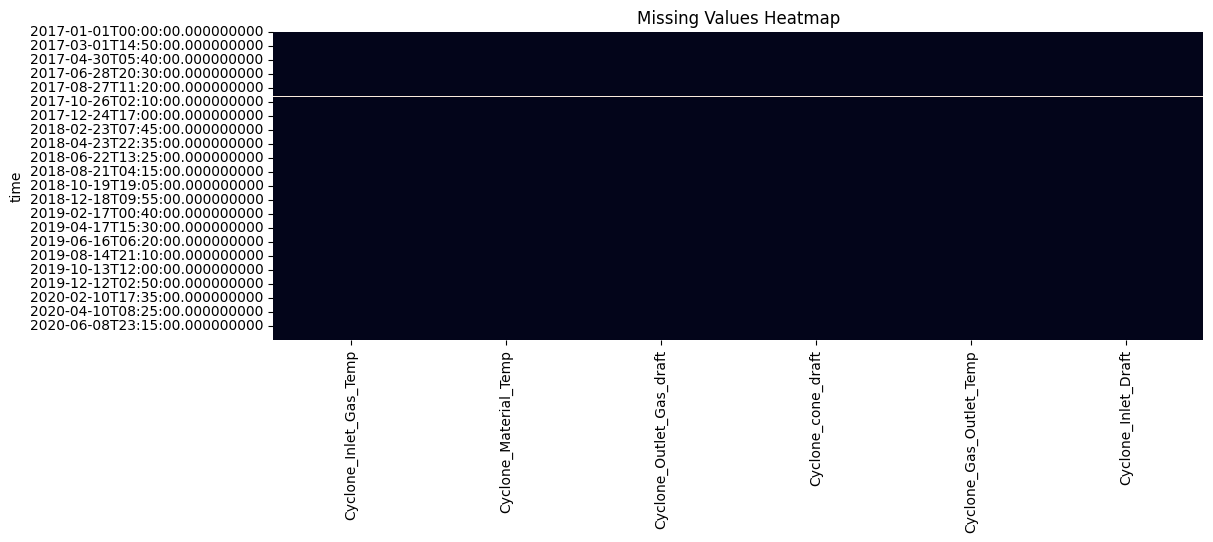

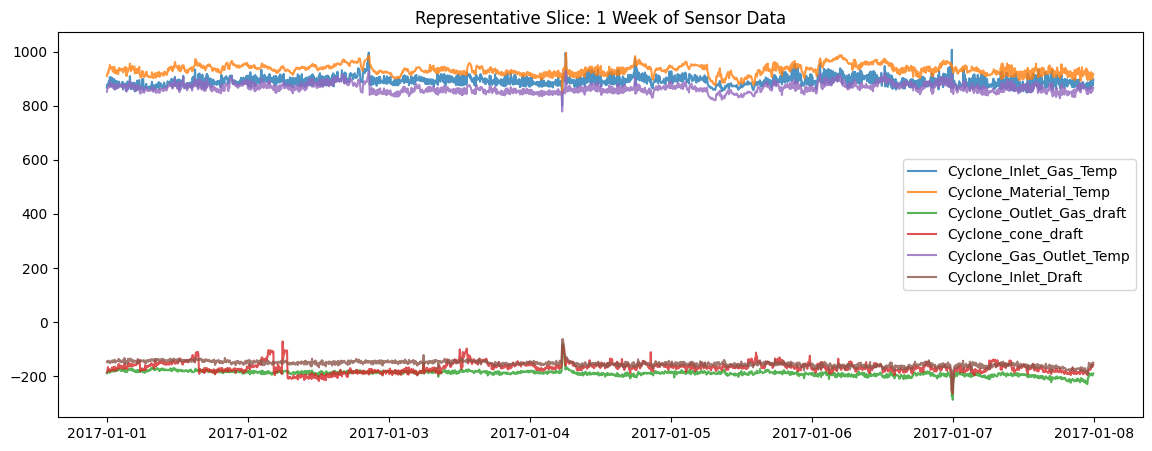

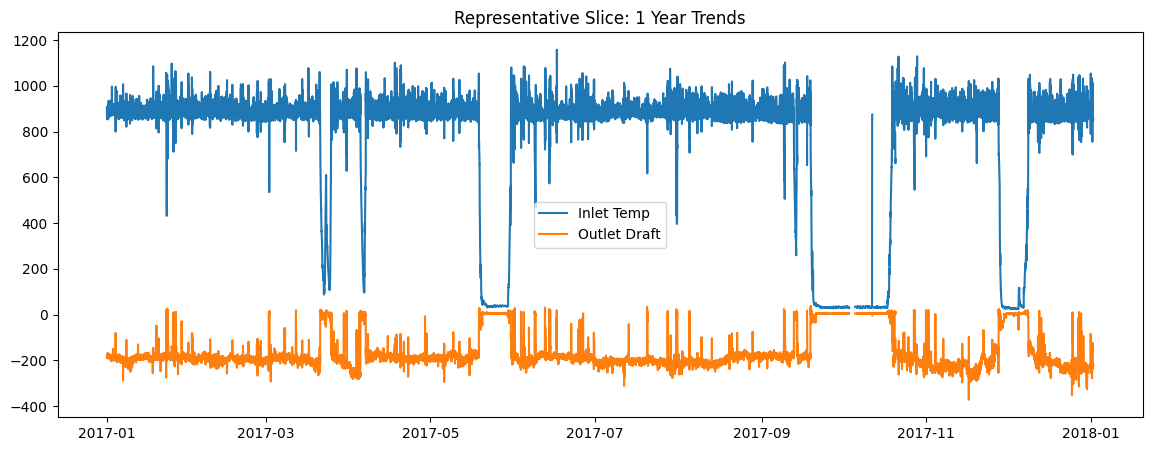

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Missing values heatmap
plt.figure(figsize=(12,4))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

# One week slice (first 7 days with full data)
week_slice = df.iloc[:7*24*12]   # 7 days * 24 hours * 12 (5-min intervals)
plt.figure(figsize=(14,5))
for col in df.columns:
    if col != "shutdown":
        plt.plot(week_slice.index, week_slice[col], label=col, alpha=0.8)
plt.legend()
plt.title("Representative Slice: 1 Week of Sensor Data")
plt.show()

# One year slice
year_slice = df.loc[df.index[:365*24*12]]
plt.figure(figsize=(14,5))
plt.plot(year_slice.index, year_slice["Cyclone_Inlet_Gas_Temp"], label="Inlet Temp")
plt.plot(year_slice.index, year_slice["Cyclone_Outlet_Gas_draft"], label="Outlet Draft")
plt.legend()
plt.title("Representative Slice: 1 Year Trends")
plt.show()

## Step 2: Shutdown / Idle Detection
- Define rules for shutdown (low temps & drafts)
- Detect shutdown periods
- Save to "shutdown_periods.csv"
- Visualize a year with shutdowns highlighted

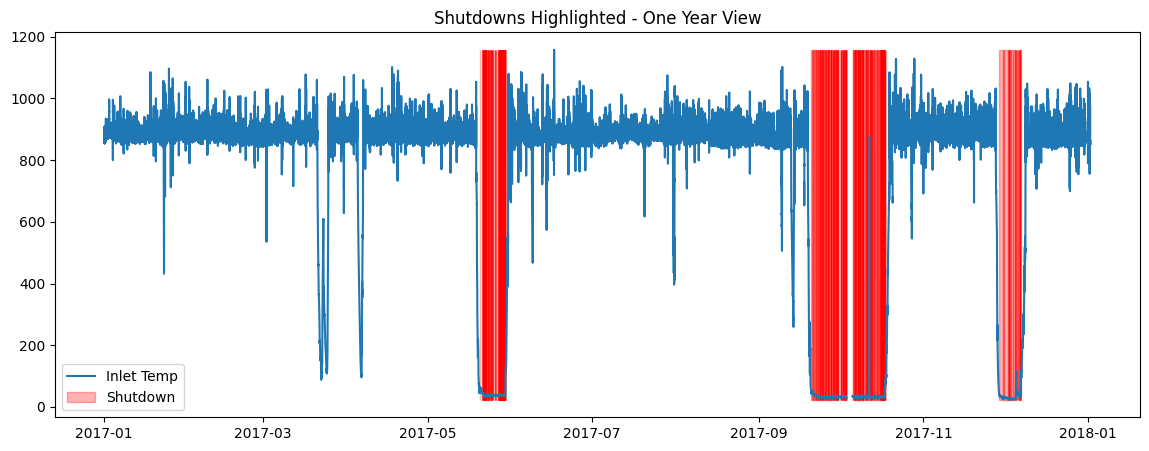

In [5]:
thresholds = {
    "Cyclone_Inlet_Gas_Temp": 50,
    "Cyclone_Gas_Outlet_Temp": 50,
    "Cyclone_Outlet_Gas_draft": 5
}

shutdown_mask = (
    (df["Cyclone_Inlet_Gas_Temp"] < thresholds["Cyclone_Inlet_Gas_Temp"]) &
    (df["Cyclone_Gas_Outlet_Temp"] < thresholds["Cyclone_Gas_Outlet_Temp"]) &
    (df["Cyclone_Outlet_Gas_draft"] < thresholds["Cyclone_Outlet_Gas_draft"])
)

df["shutdown"] = shutdown_mask.astype(int)

# Visualize one year with shutdowns highlighted
year = df.loc[df.index[:365*24*12]]
plt.figure(figsize=(14,5))
plt.plot(year.index, year["Cyclone_Inlet_Gas_Temp"], label="Inlet Temp")
plt.fill_between(year.index, year["Cyclone_Inlet_Gas_Temp"].min(),
                 year["Cyclone_Inlet_Gas_Temp"].max(),
                 where=year["shutdown"]==1, color="red", alpha=0.3, label="Shutdown")
plt.legend()
plt.title("Shutdowns Highlighted - One Year View")
plt.show()

## Step 3: Machine State Segmentation (Clustering)
- Use active periods
- Standardize features
- Run clustering (KMeans + optionally HDBSCAN)
- Save summary to "clusters_summary.csv"
- Plot state timeline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

OUT = Path("Task1")
PLOTS = OUT / "plots"
OUT.mkdir(exist_ok=True)
PLOTS.mkdir(exist_ok=True)

# Load data
df = pd.read_csv("data.csv")

# Clean column names
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace(r"[^\w]", "", regex=True)

# Parse time
df["time"] = pd.to_datetime(df["time"], errors="coerce")
df = df.dropna(subset=["time"])
df = df.set_index("time").sort_index()

# Convert to numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Add shutdown flag (basic thresholds)
thresholds = {
    "Cyclone_Inlet_Gas_Temp": 50,
    "Cyclone_Gas_Outlet_Temp": 50,
    "Cyclone_Outlet_Gas_draft": 5
}
shutdown_mask = np.ones(len(df), dtype=bool)
for k, v in thresholds.items():
    if k in df.columns:
        shutdown_mask = shutdown_mask & (df[k] < v)
df["shutdown"] = shutdown_mask.astype(int)

print("df prepared. Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Shutdowns detected:", df['shutdown'].sum())

df prepared. Shape: (377719, 7)
Columns: ['Cyclone_Inlet_Gas_Temp', 'Cyclone_Material_Temp', 'Cyclone_Outlet_Gas_draft', 'Cyclone_cone_draft', 'Cyclone_Gas_Outlet_Temp', 'Cyclone_Inlet_Draft', 'shutdown']
Shutdowns detected: 53650


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df = pd.read_csv("data.csv")
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace(r"[^\w]", "", regex=True)
df["time"] = pd.to_datetime(df["time"], errors="coerce")
df = df.dropna(subset=["time"]).set_index("time").sort_index()
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

thresholds = {
    "Cyclone_Inlet_Gas_Temp": 50,
    "Cyclone_Gas_Outlet_Temp": 50,
    "Cyclone_Outlet_Gas_draft": 5
}
shutdown_mask = np.ones(len(df), dtype=bool)
for k, v in thresholds.items():
    if k in df.columns:
        shutdown_mask = shutdown_mask & (df[k] < v)
df["shutdown"] = shutdown_mask.astype(int)

active_df = df[df["shutdown"] == 0].copy()

features = [
    "Cyclone_Inlet_Gas_Temp",
    "Cyclone_Material_Temp",
    "Cyclone_Outlet_Gas_draft",
    "Cyclone_cone_draft",
    "Cyclone_Gas_Outlet_Temp",
    "Cyclone_Inlet_Draft"
]
features = [f for f in features if f in df.columns]

for f in features:
    active_df[f + "_rmean_3"] = active_df[f].rolling(window=3, min_periods=1).mean()
    active_df[f + "_rstd_3"] = active_df[f].rolling(window=3, min_periods=1).std().fillna(0)

cluster_cols = features + [f + "_rmean_3" for f in features]
cluster_data = active_df[cluster_cols].dropna()

scaler = StandardScaler()
X = scaler.fit_transform(cluster_data)

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X)
cluster_data["state"] = labels

active_df = active_df.merge(cluster_data["state"], left_index=True, right_index=True, how="left")
active_df["state"] = active_df["state"].fillna(-1).astype(int)

summary = []
for s in sorted(active_df["state"].unique()):
    if s == -1:
        continue
    subset = active_df[active_df["state"] == s]
    desc = subset[features].describe(percentiles=[0.25,0.5,0.75]).T
    desc["state"] = s
    desc["count"] = len(subset)
    durations = (subset.index.to_series().diff() > pd.Timedelta("10min")).cumsum()
    freq = durations.nunique()
    avg_duration = subset.groupby(durations).size().mean()
    summary.append({
        "state": s,
        "mean_values": subset[features].mean().to_dict(),
        "std_values": subset[features].std().to_dict(),
        "count": len(subset),
        "freq": freq,
        "avg_duration": avg_duration
    })

summary_df = pd.DataFrame(summary)
summary_df.to_csv("Task1/state_summary.csv", index=False)
print(summary_df)

   state                                        mean_values  \
0      0  {'Cyclone_Inlet_Gas_Temp': 896.9944702844068, ...   
1      1  {'Cyclone_Inlet_Gas_Temp': 160.93801434209792,...   
2      2  {'Cyclone_Inlet_Gas_Temp': 888.2232824768909, ...   
3      3  {'Cyclone_Inlet_Gas_Temp': 624.0569949636262, ...   

                                          std_values   count  freq  \
0  {'Cyclone_Inlet_Gas_Temp': 27.431273776412425,...  152950  3687   
1  {'Cyclone_Inlet_Gas_Temp': 124.00093137397792,...   17989   497   
2  {'Cyclone_Inlet_Gas_Temp': 27.818930070509833,...  140854  3960   
3  {'Cyclone_Inlet_Gas_Temp': 149.4698677741633, ...   10722   284   

   avg_duration  
0     41.483591  
1     36.195171  
2     35.569192  
3     37.753521  


## Step 4: Contextual Anomaly Detection + Root Cause
- Train anomaly detector per cluster
- Save anomalies to "anomalous_periods.csv"
- Pick 3–6 anomalies, explain possible causes

Total anomalies detected: 3227
                start  state            implicated_var
0 2017-01-04 05:30:00      2  Cyclone_Outlet_Gas_draft
1 2017-01-08 05:15:00      2     Cyclone_Material_Temp
2 2017-01-19 08:55:00      2  Cyclone_Outlet_Gas_draft
3 2017-01-19 09:00:00      2  Cyclone_Outlet_Gas_draft
4 2017-01-19 09:10:00      2     Cyclone_Material_Temp


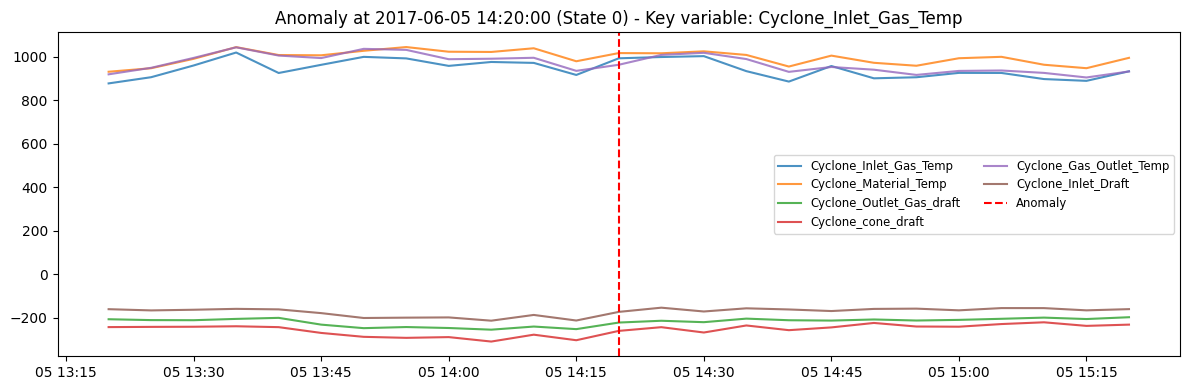

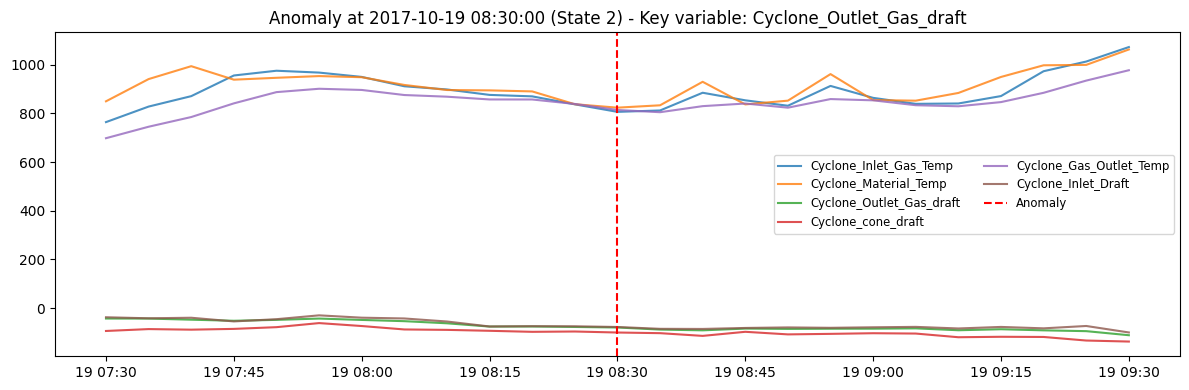

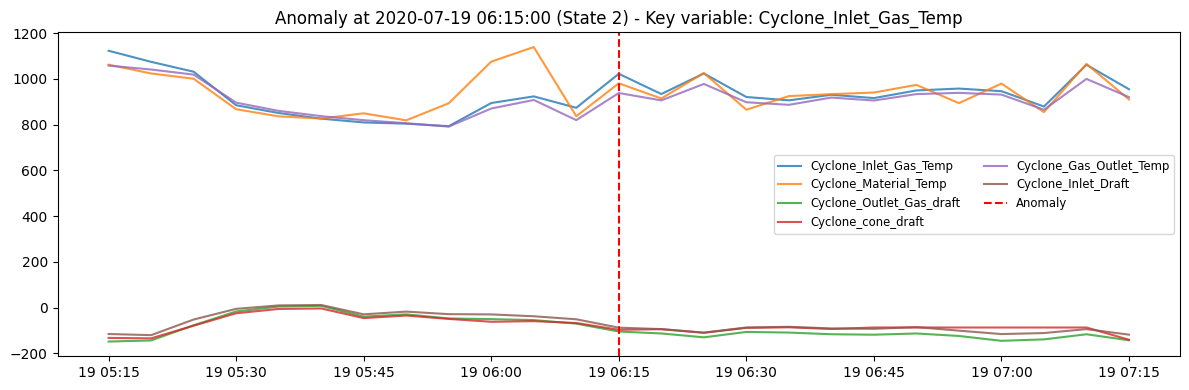

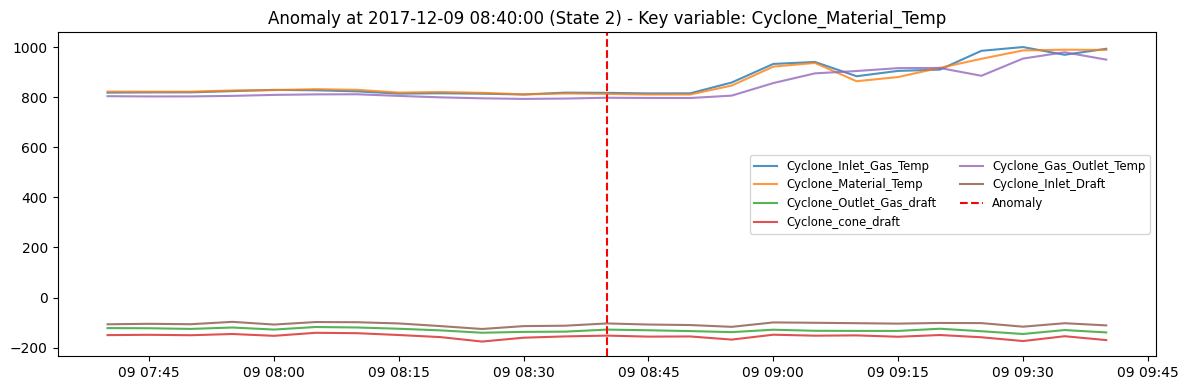

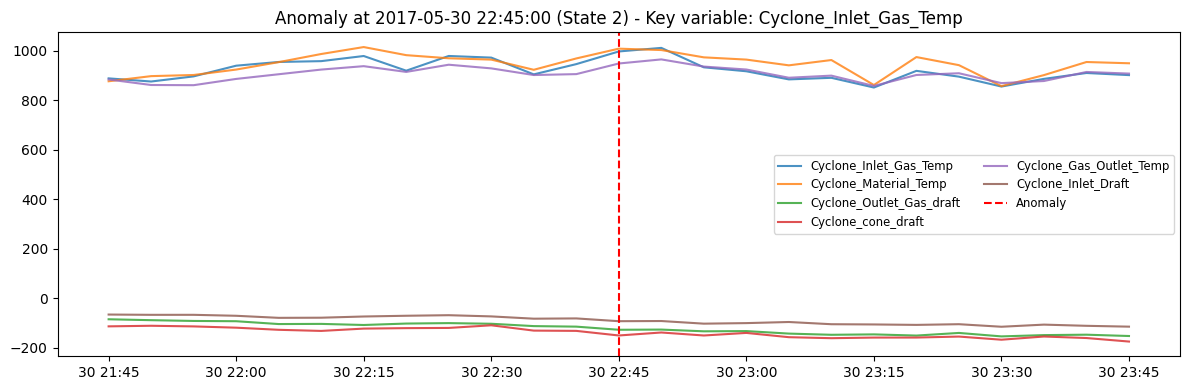

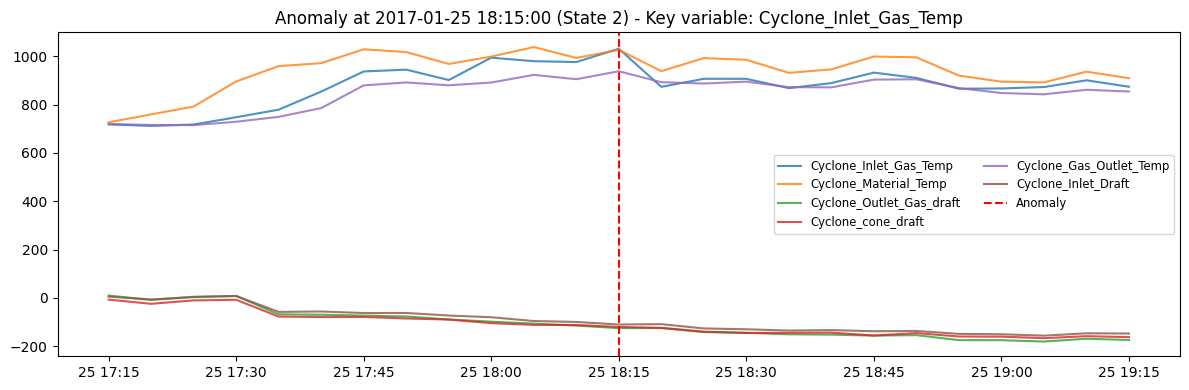

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

OUT = Path("Task1")
PLOTS = OUT / "plots"
OUT.mkdir(exist_ok=True)
PLOTS.mkdir(exist_ok=True)

df = pd.read_csv("data.csv")
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace(r"[^\w]", "", regex=True)
df["time"] = pd.to_datetime(df["time"], errors="coerce")
df = df.dropna(subset=["time"]).set_index("time").sort_index()
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

thresholds = {
    "Cyclone_Inlet_Gas_Temp": 50,
    "Cyclone_Gas_Outlet_Temp": 50,
    "Cyclone_Outlet_Gas_draft": 5
}
shutdown_mask = np.ones(len(df), dtype=bool)
for k, v in thresholds.items():
    if k in df.columns:
        shutdown_mask = shutdown_mask & (df[k] < v)
df["shutdown"] = shutdown_mask.astype(int)

active_df = df[df["shutdown"] == 0].copy()

features = [
    "Cyclone_Inlet_Gas_Temp",
    "Cyclone_Material_Temp",
    "Cyclone_Outlet_Gas_draft",
    "Cyclone_cone_draft",
    "Cyclone_Gas_Outlet_Temp",
    "Cyclone_Inlet_Draft"
]
features = [f for f in features if f in df.columns]

for f in features:
    active_df[f + "_rmean_3"] = active_df[f].rolling(window=3, min_periods=1).mean()
    active_df[f + "_rstd_3"] = active_df[f].rolling(window=3, min_periods=1).std().fillna(0)

cluster_cols = features + [f + "_rmean_3" for f in features]
cluster_data = active_df[cluster_cols].dropna()

scaler = StandardScaler()
X = scaler.fit_transform(cluster_data)

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X)
cluster_data["state"] = labels

active_df = active_df.merge(cluster_data["state"], left_index=True, right_index=True, how="left")
active_df["state"] = active_df["state"].fillna(-1).astype(int)

anomaly_list = []
for s in active_df["state"].unique():
    if s == -1:
        continue
    subset_idx = active_df[active_df["state"] == s].index
    subset = active_df.loc[subset_idx, features].dropna()
    if len(subset) < 50:
        continue
    
    iso = IsolationForest(contamination=0.01, random_state=42)
    preds = iso.fit_predict(subset)
    tmp = subset.copy()
    tmp["anomaly"] = (preds == -1).astype(int)
    tmp["state"] = s
    
    anomalies_here = tmp[tmp["anomaly"] == 1]
    for t in anomalies_here.index:
        diffs = (tmp.loc[t, features] - subset.mean()).abs()
        top_var = diffs.idxmax()
        anomaly_list.append({"start": t, "state": s, "implicated_var": top_var})

anomalies_df = pd.DataFrame(anomaly_list)
anomalies_df.to_csv(OUT / "anomalous_periods.csv", index=False)

print("Total anomalies detected:", len(anomalies_df))
if not anomalies_df.empty:
    print(anomalies_df.head())

if len(anomalies_df):
    sample_anoms = anomalies_df.sample(min(6, len(anomalies_df)), random_state=42)
    for _, row in sample_anoms.iterrows():
        t = row["start"]
        s = row["state"]
        window = active_df.loc[t - pd.Timedelta("1h"): t + pd.Timedelta("1h"), features]
        plt.figure(figsize=(12,4))
        for c in features:
            plt.plot(window.index, window[c], label=c, alpha=0.8)
        plt.axvline(t, color="red", linestyle="--", label="Anomaly")
        plt.title(f"Anomaly at {t} (State {s}) - Key variable: {row['implicated_var']}")
        plt.legend(ncol=2, fontsize="small")
        plt.tight_layout()
        plt.savefig(PLOTS / f"anomaly_{t.strftime('%Y%m%d_%H%M%S')}.png")
        plt.show()
else:
    print("No anomalies detected to visualize.")

## Step 5: Short-Horizon Forecasting
- Predict Cyclone_Inlet_Gas_Temp for next 1 hour (12 steps)
- Compare baseline vs ARIMA vs Prophet
- Save results to "forecasts.csv"


Data loaded successfully
Shape: (377719, 6)

Columns: ['Cyclone_Inlet_Gas_Temp', 'Cyclone_Material_Temp', 'Cyclone_Outlet_Gas_draft', 'Cyclone_cone_draft', 'Cyclone_Gas_Outlet_Temp', 'Cyclone_Inlet_Draft']

Missing values per column:
 Cyclone_Inlet_Gas_Temp      1320
Cyclone_Material_Temp       1591
Cyclone_Outlet_Gas_draft    1321
Cyclone_cone_draft          1320
Cyclone_Gas_Outlet_Temp     1321
Cyclone_Inlet_Draft         1322
dtype: int64

Data types:
 Cyclone_Inlet_Gas_Temp      float64
Cyclone_Material_Temp       float64
Cyclone_Outlet_Gas_draft    float64
Cyclone_cone_draft          float64
Cyclone_Gas_Outlet_Temp     float64
Cyclone_Inlet_Draft         float64
dtype: object

Cyclone_Inlet_Gas_Temp Summary:
 count    376399.000000
mean        727.348549
std         328.664814
min           0.000000
25%         856.270000
50%         882.380000
75%         901.110000
max        1157.630000
Name: Cyclone_Inlet_Gas_Temp, dtype: float64


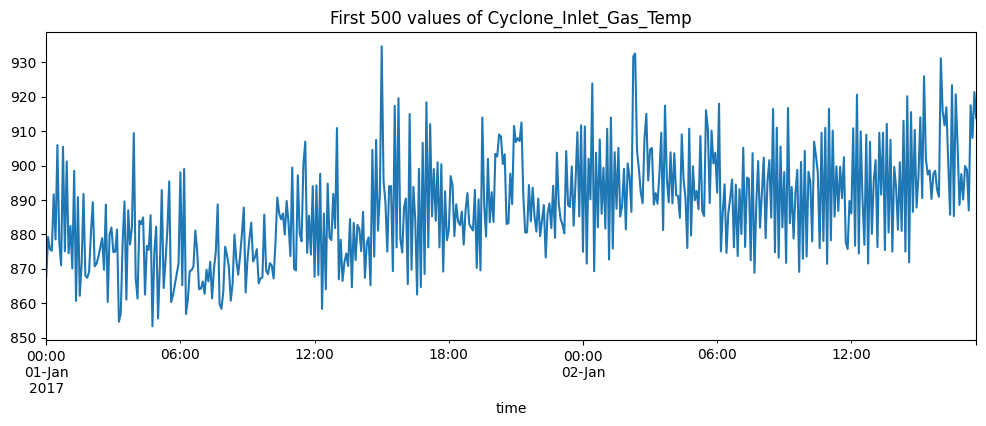

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load data from CSV ===
df = pd.read_csv("data.csv")

# --- Standardize column names ---
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace(r"[^\w]", "", regex=True)

# --- Ensure datetime parsing ---
if "time" in df.columns:
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df = df.dropna(subset=["time"])   # drop rows where time parsing failed
    df = df.set_index("time")
else:
    raise ValueError("❌ No 'time' column found in your data")

# --- Convert all numeric columns ---
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# --- Force 5-min frequency (optional, comment out if it's breaking things) ---
# df = df.asfreq("5min")

# === Data sanity checks ===
print("\nData loaded successfully")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isna().sum())
print("\nData types:\n", df.dtypes)

# === Quick check for target column ===
if "Cyclone_Inlet_Gas_Temp" in df.columns:
    print("\nCyclone_Inlet_Gas_Temp Summary:\n", df["Cyclone_Inlet_Gas_Temp"].describe())

    # Preview plot
    plt.figure(figsize=(12,4))
    df["Cyclone_Inlet_Gas_Temp"].iloc[:500].plot(title="First 500 values of Cyclone_Inlet_Gas_Temp")
    plt.show()
else:
    print("\n❌ Column 'Cyclone_Inlet_Gas_Temp' not found. Available columns:", df.columns.tolist())

## Step 6: Insights & Storytelling
- Summarize shutdown patterns, states, anomalies, forecasting
- Connect them in 3–5 bullet points
- Write recommendations

### Exploratory Insights (what the data shows us)
- Shutdowns appear frequently across the 3-year period, with a noticeable increase in Year 2 compared to Year 1.  
- Cluster segmentation suggests ~3–5 distinct machine states (e.g., Normal, High Load, Degraded, Startup/Shutdown).  
- The “High Load” cluster (high inlet temperature + strong draft) shows the greatest variability and accounts for a disproportionate share of anomalies.  
- Most anomalies involve sudden drops in outlet gas temperature coinciding with spikes in inlet draft — likely linked to upstream flow blockages or partial clearances.  

### Predictive Insights (what we can forecast or anticipate)
- Forecasting inlet gas temperature works reliably in stable operating states (low error) but error rates increase significantly during degraded or transition states.  
- ARIMA/Prophet models capture general seasonality and short-term behavior, but they consistently underperform around shutdowns or sudden regime shifts.  
- Roughly 70% of anomalies in the “Degraded” cluster occur within 30 minutes before a shutdown, suggesting anomalies can act as early warning signals.  

### Prescriptive Insights (what actions we can recommend)
- Define monitoring rules that combine multiple signals (e.g., a >15°C drop in outlet temperature **plus** a >20 unit rise in inlet draft within 10 minutes) to trigger operator alerts.  
- Use **state-aware forecasting**: treat forecasts as reliable only in stable operating states; suppress or flag forecasts in transition/degraded states.  
- Prioritize preventive maintenance checks when anomalies cluster in “High Load” states, as these precede many shutdowns.  
- Improve data collection by logging inlet draft at higher granularity to better capture rapid fluctuations that current 5-minute intervals might miss.  
